<a href="https://colab.research.google.com/github/danglive/Optimization-tutorial/blob/master/BayesianOpt_for_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
# Install the library opt
!pip install scikit-optimize

In [0]:
# Import the libraries
import skopt
from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args
import tensorflow as tf
import numpy as np
import pandas as pd
from math import sqrt
import atexit
from time import time, strftime, localtime
from datetime import timedelta
from sklearn.metrics import mean_squared_error
from  skopt.plots import plot_convergence

In [0]:
# Setting the defaut values
randomState = 46
np.random.seed(randomState)
tf.set_random_seed(randomState)


input_size=1
num_layers=1
features = 2
column_min_max = [[0, 2000],[0,500000000]]
columns = ['Close', 'Volume']


num_steps = None
lstm_size = None
batch_size = None
init_learning_rate = None
learning_rate_decay = None
init_epoch = None
max_epoch = None
dropout_rate = None

In [0]:
lstm_num_steps = Integer(low=2, high=14, name='lstm_num_steps')
size = Integer(low=8, high=200, name='size')
lstm_learning_rate_decay = Real(low=0.7, high=0.99, prior='uniform', name='lstm_learning_rate_decay')
lstm_max_epoch = Integer(low=20, high=200, name='lstm_max_epoch')
lstm_init_epoch = Integer(low=2, high=50, name='lstm_init_epoch')
lstm_batch_size = Integer(low=5, high=100, name='lstm_batch_size')
lstm_dropout_rate = Real(low=0.1, high=0.9, prior='uniform', name='lstm_dropout_rate')
lstm_init_learning_rate = Real(low=1e-4, high=1e-1, prior='log-uniform', name='lstm_init_learning_rate')

In [0]:
dimensions = [lstm_num_steps, size, lstm_init_epoch, lstm_max_epoch,
              lstm_learning_rate_decay, lstm_batch_size, lstm_dropout_rate, lstm_init_learning_rate]

In [0]:
default_parameters = [2,128,3,30,0.99,64,0.2,0.001]

#------------ to log execution time ---------------------------------

In [0]:
def secondsToStr(elapsed=None):
    if elapsed is None:
        return strftime("%Y-%m-%d %H:%M:%S", localtime())
    else:
        return str(timedelta(seconds=elapsed))

In [0]:
def logger(s, elapsed=None):
    line = "=" * 40
    print(line)
    print(secondsToStr(), '-', s)
    if elapsed:
        print("Elapsed time:", elapsed)
    print(line)
    print()

In [0]:
def endlog():
    end = time()
    elapsed = end - start
    logger("End Program", secondsToStr(elapsed))

#------------ generate data batches ---------------------------------

In [0]:
def generate_batches(train_X, train_y, batch_size):
    num_batches = int(len(train_X)) // batch_size
    if batch_size * num_batches < len(train_X):
        num_batches += 1

    batch_indices = range(num_batches)
    for j in batch_indices:
        batch_X = train_X[j * batch_size: (j + 1) * batch_size]
        batch_y = train_y[j * batch_size: (j + 1) * batch_size]
        yield batch_X, batch_y

In [0]:
def segmentation(data):

    seq = [price for tup in data[['Close', 'Volume']].values for price in tup]

    seq = np.array(seq)

    # split into items of features
    seq = [np.array(seq[i * features: (i + 1) * features])
           for i in range(len(seq) // features)]

    # split into groups of num_steps
    X = np.array([seq[i: i + num_steps] for i in range(len(seq) - num_steps)])

    y = np.array([seq[i + num_steps] for i in range(len(seq) - num_steps)])

    # get only sales value
    y = [[y[i][0]] for i in range(len(y))]

    y = np.asarray(y)

    return X, y

In [0]:
def scale(data):
    for i in range(len(column_min_max)):
        data[columns[i]] = (data[columns[i]] - column_min_max[i][0]) / ((column_min_max[i][1]) - (column_min_max[i][0]))

    return data

In [0]:
def rescle(test_pred):
    prediction = [(pred * (column_min_max[0][1] - column_min_max[0][0])) + column_min_max[0][0] for pred in test_pred]
    return prediction

#------------ fucntion that governs data pre-processing -------------------------------

In [0]:
def pre_process():
    url = 'https://raw.githubusercontent.com/danglive/Optimization-tutorial/master/AIG.csv'
    stock_data = pd.read_csv(url)
    stock_data = stock_data.reindex(index=stock_data.index[::-1])

    vali_ratio = 0.2
    test_ratio = 0.5

    train_size = int(len(stock_data) * (1.0 - vali_ratio))
    temp_len = len(stock_data)-train_size
    validation_len = int(temp_len * (1.0 - test_ratio))
    #the final 5% of the data will be for the test set

    train_data = stock_data[:train_size]
    validation_data = stock_data[(train_size - num_steps): validation_len + train_size]
    original_val_data = validation_data.copy()

    # -------------- processing train data---------------------------------------
    scaled_train_data = scale(train_data)
    train_X, train_y = segmentation(scaled_train_data)

    # -------------- processing validation data---------------------------------------
    scaled_validation_data = scale(validation_data)
    val_X, val_y = segmentation(scaled_validation_data)

    # ----segmenting original validation data-----------------------------------------------
    nonescaled_val_X, nonescaled_val_y = segmentation(original_val_data)


    return train_X, train_y, val_X, val_y, nonescaled_val_y

#------------ RNN model ---------------------------------

In [0]:
def setupRNN(inputs,model_dropout_rate):


    cell = tf.contrib.rnn.LSTMCell(lstm_size, state_is_tuple=True, activation=tf.nn.tanh,use_peepholes=True)

    val1, _ = tf.nn.dynamic_rnn(cell, inputs, dtype=tf.float32)

    val = tf.transpose(val1, [1, 0, 2])

    last = tf.gather(val, int(val.get_shape()[0]) - 1, name="last_lstm_output")

    dropout = tf.layers.dropout(last, rate=model_dropout_rate, training=True,seed=46)

    weight = tf.Variable(tf.truncated_normal([lstm_size, input_size]))
    bias = tf.Variable(tf.constant(0.1, shape=[input_size]))

    prediction = tf.matmul(dropout, weight) + bias

    return prediction

#------------ function returned to Bayesian Optimization ---------------------------------

In [0]:
@use_named_args(dimensions=dimensions)
def fitness(lstm_num_steps, size, lstm_init_epoch, lstm_max_epoch,
              lstm_learning_rate_decay, lstm_batch_size, lstm_dropout_rate, lstm_init_learning_rate):

    global  iteration, num_steps, lstm_size, init_epoch, max_epoch, learning_rate_decay, dropout_rate, init_learning_rate, batch_size

    num_steps = np.int32(lstm_num_steps)
    lstm_size = np.int32(size)
    batch_size = np.int32(lstm_batch_size)
    learning_rate_decay = np.float32(lstm_learning_rate_decay)
    init_epoch = np.int32(lstm_init_epoch)
    max_epoch = np.int32(lstm_max_epoch)
    dropout_rate = np.float32(lstm_dropout_rate)
    init_learning_rate = np.float32(lstm_init_learning_rate)

    tf.reset_default_graph()
    tf.set_random_seed(randomState)
    sess = tf.Session()

    train_X, train_y, val_X, val_y,  nonescaled_val_y = pre_process()

    inputs = tf.placeholder(tf.float32, [None, num_steps, features], name="inputs")
    targets = tf.placeholder(tf.float32, [None, input_size], name="targets")
    model_learning_rate = tf.placeholder(tf.float32, None, name="learning_rate")
    model_dropout_rate = tf.placeholder_with_default(0.0, shape=())
    global_step = tf.Variable(0, trainable=False)

    prediction = setupRNN(inputs,model_dropout_rate)

    model_learning_rate = tf.train.exponential_decay(learning_rate=model_learning_rate, global_step=global_step, decay_rate=learning_rate_decay,
                                               decay_steps=init_epoch, staircase=False)

    with tf.name_scope('loss'):
        model_loss = tf.losses.mean_squared_error(targets, prediction)

    with tf.name_scope('adam_optimizer'):
        train_step = tf.train.AdamOptimizer(model_learning_rate).minimize(model_loss,global_step=global_step)


    sess.run(tf.global_variables_initializer())

    for epoch_step in range(max_epoch):

        for batch_X, batch_y in generate_batches(train_X, train_y, batch_size):
            train_data_feed = {
                inputs: batch_X,
                targets: batch_y,
                model_learning_rate: init_learning_rate,
                model_dropout_rate: dropout_rate
            }
            sess.run(train_step, train_data_feed)

    val_data_feed = {
        inputs: val_X,
    }
    vali_pred = sess.run(prediction, val_data_feed)

    vali_pred_vals = rescle(vali_pred)

    vali_pred_vals = np.array(vali_pred_vals)

    vali_pred_vals = vali_pred_vals.flatten()

    vali_pred_vals = vali_pred_vals.tolist()

    vali_nonescaled_y = nonescaled_val_y.flatten()

    vali_nonescaled_y = vali_nonescaled_y.tolist()

    val_error = sqrt(mean_squared_error(vali_nonescaled_y, vali_pred_vals))

    return val_error

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use keras.layers.dropout instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of 

[7, 187, 3, 162, 0.7202483020057686, 68, 0.19990965258462956, 0.0001926747183217011]
2.981700600703449
2019-11-19 17:57:30 - Start Program



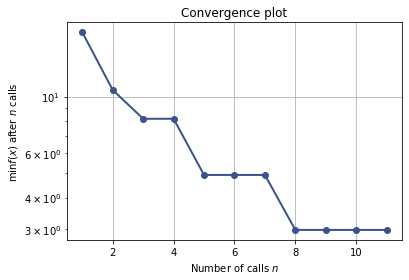

In [28]:
if __name__ == '__main__':

    start = time()

    search_result = gp_minimize(func=fitness,
                                dimensions=dimensions,
                                acq_func='EI',  # Expected Improvement.
                                n_calls=11,
                                x0=default_parameters,
                                random_state=46)

    print(search_result.x)
    print(search_result.fun)
    plot = plot_convergence(search_result,yscale="log")


    atexit.register(endlog)
    logger("Start Program")